# Car Market Study

The website [Standvirtual](https://wwww.standvirtual.com) was scrapped. This website contains 2nd hand cars for sale.

By analysing the data we may find opportunities to buy used cars and determine the value of cars given their characteristics.

In the first part we try to some statistics about the general dataset (data exploration). The goal with this part is to identify general trends in the market value of cars in the different segments. Afterwards, a model will be built to predict the price for an ad listing, given the car characteristics.

General information about the dataset:
* The dataset contains 41.106 ad listings with a total value of EUR 1.09 billion, with an average price tag of EUR 26.508 and average kilometers of 103.542
* In Portugal the passenger car fleet is around 5.8 million cars, as such these ad listings represent around 0.70% of the Portuguese passenger vehicle [car parc](https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_publicacoes&PUBLICACOESpub_boui=637258119&PUBLICACOESmodo=2)
* The car model with most ad listings is the Renault Clio
* 32% of the ad listings are from from the last 3 years
* 48% cars for sale are Diesel
* There seems to be a significant incidence of EV vehicles for sales
    * Even though the share of EV cars (*100% Electric + Plug-In*) in new car sales in Portugal was 31% in 2023 (21% in 2022), the  car parc of these EV vehicles was only around 228.140 in 2023 (under 4% of the total car parc). However, the number of EVs for sale on *Standvirtual* is 5.999, representing 1.8% of the EV car parc (assuming the car parc of 228k grew by 81k in 2024, also assuming 32% of new car sales were EVs). This compares with a car parc of around 4.7 million diesel vehicles and 19.789 ad listings, or 0.42% of the diesel car parc.

In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler  # Include PolynomialFeatures here
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from unidecode import unidecode
import re

## 1. Data Analysis

In [3]:
df = pd.read_csv(
    "car-data.csv",
    sep=";",
    header=0,
    encoding="utf-8"
)

# visualise the first 15 entries
df.head(15)

,Brand,Title,Kilometer,Gas Type,Gear Box,Year,Price
0,Abarth,Abarth 595 Turismo,145 000,Gasolina,Manual,2015,16 000
1,Abarth,Abarth 500e,NaN,Eléctrico,Automática,2024,37 981
2,Abarth,Abarth 695 1.4 T-Jet MTA,NaN,Gasolina,Automática,2024,36 612
3,Abarth,Abarth 500 1.4 16V,122 000,Gasolina,Manual,2009,13 990
4,Abarth,Abarth 595 1.4 T-Jet Competizione MTA,134 000,Gasolina,Automática,2016,18 999
5,Abarth,Abarth 500C 1.4 16V Auto,129 000,Gasolina,Automática,2010,15 600
6,Abarth,Abarth 595 1.4 T-Jet Turismo,39 000,Gasolina,Manual,2021,26 990
7,Abarth,Abarth Grande Punto 1.4 T-Jet Supersport,100 000,Gasolina,Manual,2008,13 900
8,Abarth,Abarth 595 1.4 T-Jet Competizione,33 000,Gasolina,Manual,2019,26 990
9,Abarth,Abarth 595,13 000,Gasolina,Manual,2021,23 500


### 1.1 The Dataset

The dataset shown above has the following features:
- Brand -> Manufacturer of the vehicle. Categorical type;
- Title -> Title of the advertisement. Contains information about the model of the car. It is a categorical variable;
- Kilometer -> Number of kilometers the vehicle has travelled. It is an important measure of its usage. It is a numeric variable;
- Kilometer Bracket -> The interval of kilometers which contains the number of kilometers of the vehicle. Categorical variable;
- Gas type -> Gasolina, Hibrido Plug-in, Gasoleo, etc... Categorical variable;
- Gear box -> Either manual or automatic. Categorical variable;
- Year -> Year of the vehicle's production; Numerical variable;
- Year bracket -> The interval which contains the year of the vehicle's production. Treated as a Categorical variable;
- Price -> target $Y$ variable. It is the price at which the vehicle is being promoted in the website. 


In [4]:
len(df)

41106

In total there are 41 106 car promotions in the website *StandVirtual*.

Number of different car brands being promoted:

In [5]:
len(df["Brand"].unique())

88

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41106 entries, 0 to 41105
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Brand      41106 non-null  object
 1   Title      41106 non-null  object
 2   Kilometer  41092 non-null  object
 3   Gas Type   41105 non-null  object
 4   Gear Box   41091 non-null  object
 5   Year       41105 non-null  object
 6   Price      41104 non-null  object
dtypes: object(7)
memory usage: 2.2+ MB


Observation: The variable Kilometer is not being stored as a number. The problem is that whitespace is being used as the thousand separator.

We can use string methods to delete whitespace characters from this particular column and try to convert the value to integer. Some of those whitespace characters are *\xa0* the non-breaking space. Replacing them requires the prefix *u* before the string literals. The actual whitespaces are replaced without the prefix.

### 1.2 Data Treatment


In [7]:
# Observe if column 'Kilometer' has a space 
df["Kilometer"]

0        145 000
1            NaN
2            NaN
3        122 000
4        134 000
          ...   
41101     94 737
41102     88 000
41103      2 500
41104      8 900
41105        500
Name: Kilometer, Length: 41106, dtype: object

In [8]:
# Correct space within column 'Kilometer', by replacing whitespaces
df["Kilometer"] = df["Kilometer"].str.replace(" ", "")

In [9]:
df["Kilometer"]

0        145000
1           NaN
2           NaN
3        122000
4        134000
          ...  
41101     94737
41102     88000
41103      2500
41104      8900
41105       500
Name: Kilometer, Length: 41106, dtype: object

The price feature also suffers from the same problem. Hence, we apply the same methods to eliminate the *\xa0* characters

In [10]:
# Observe if column 'Price' has a space 
df["Price"][0]

'16 000'

In [11]:
# Correct space within column 'Price', by replacing whitespaces
df["Price"] = df["Price"].str.replace(" ", "")
df["Price"]

0        16000
1        37981
2        36612
3        13990
4        18999
         ...  
41101    13900
41102    38900
41103    15250
41104    16500
41105    16500
Name: Price, Length: 41106, dtype: object

And now we convert both the Kilometer and Price features to numeric values.

In [12]:
df["Price"] = pd.to_numeric(df["Price"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41106 entries, 0 to 41105
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Brand      41106 non-null  object 
 1   Title      41106 non-null  object 
 2   Kilometer  41092 non-null  object 
 3   Gas Type   41105 non-null  object 
 4   Gear Box   41091 non-null  object 
 5   Year       41105 non-null  object 
 6   Price      41104 non-null  float64
dtypes: float64(1), object(6)
memory usage: 2.2+ MB


In [17]:
df["Year"] = df["Year"].str.replace(" ", "")

In [18]:
df["Year"] = pd.to_numeric(df["Year"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41106 entries, 0 to 41105
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Brand      41106 non-null  object 
 1   Title      41106 non-null  object 
 2   Kilometer  41092 non-null  object 
 3   Gas Type   41105 non-null  object 
 4   Gear Box   41091 non-null  object 
 5   Year       41105 non-null  float64
 6   Price      41104 non-null  float64
dtypes: float64(2), object(5)
memory usage: 2.2+ MB


In [19]:
df[(df["Kilometer"] == "Gasolina") | (df["Kilometer"] == "Diesel")]

,Brand,Title,Kilometer,Gas Type,Gear Box,Year,Price
12014,"Supercharged""",27 800,Gasolina,Manual,2009,77500.0,NaN


In [20]:
df.iloc[12014, 0] = "Ford"
df.iloc[12014, 1] = "Ford Mustang Shelby GT500 V8 5.4 Supercharged"
df.iloc[12014, 2] = 27800
df.iloc[12014, 3] = "Gasolina"
df.iloc[12014, 4] = "Manual"
df.iloc[12014, 5] = 2009
df.iloc[12014, 6] = 77500

In [21]:
df["Kilometer"] = pd.to_numeric(df["Kilometer"])

In [23]:
df[df["Kilometer"].isna()]

,Brand,Title,Kilometer,Gas Type,Gear Box,Year,Price
1,Abarth,Abarth 500e,NaN,Eléctrico,Automática,2024.0,37981.0
2,Abarth,Abarth 695 1.4 T-Jet MTA,NaN,Gasolina,Automática,2024.0,36612.0
11007,Ford,Ford Focus 1.0 EcoBoost MHEV ST-Line,NaN,Gasolina,Manual,2024.0,31664.0
12013,Ford,Ford Mustang Shelby GT500 V8 5.4,NaN,NaN,NaN,NaN,NaN
12685,Hyundai,Hyundai i10 1.0 Comfort (TT),NaN,Gasolina,Manual,2024.0,18090.0
13428,Jaguar,Jaguar XE 2.0 i4 R-Dynamic S,NaN,Gasolina,Automática,2024.0,63260.0
13434,Jaguar,Jaguar F-Type 2.0 i4 R-Dynamic,NaN,Gasolina,Automática,2024.0,97342.0
14032,Kia,Kia EV6 77.4kWh Tech,NaN,Eléctrico,Automática,2024.0,58600.0
14033,Kia,Kia Sportage 1.6 T-GDI Drive,NaN,Gasolina,Manual,2024.0,34650.0
29515,Porsche,Porsche 718 Cayman,NaN,Gasolina,Manual,2024.0,80401.0


All cars without kilometer data are *new*, hence all of them will be set to 1

In [24]:
df["Kilometer"] = df["Kilometer"].fillna(1)

In [25]:
# Checking that there are no more missing values in Km column
df[df["Kilometer"].isna()]

,Brand,Title,Kilometer,Gas Type,Gear Box,Year,Price


In [26]:
# Show all rows with at least one missing value
df[df.isna().any(axis=1)]

,Brand,Title,Kilometer,Gas Type,Gear Box,Year,Price
2344,BMW,BMW X1 16 d sDrive xLine Auto,75479.0,Diesel,NaN,2019.0,27300.0
4765,BMW,BMW 120,139237.0,Diesel,NaN,2013.0,17990.0
12013,Ford,Ford Mustang Shelby GT500 V8 5.4,1.0,NaN,NaN,NaN,NaN
25934,Peugeot,Peugeot 208 1.2 PureTech Like,88524.0,Gasolina,NaN,2021.0,14990.0
26375,Peugeot,Peugeot 3008,69518.0,Híbrido (Gasolina),NaN,2020.0,29900.0
27605,Peugeot,Peugeot 208 1.6 BlueHDi Allure,145628.0,Diesel,NaN,2017.0,11990.0
29451,Plymouth,Plymouth Savoy,86325.0,Gasolina,NaN,1957.0,29990.0
30041,Porsche,Porsche Taycan Cross Turismo,34.0,Eléctrico,NaN,2022.0,76900.0
30297,Porsche,Porsche 911 (996),124831.0,Gasolina,NaN,2002.0,54490.0
34917,SEAT,SEAT Leon ST 1.5 TSI Xcellence DSG S/S,37501.0,Gasolina,NaN,2020.0,24400.0


Some of these missing values can be found in the actual website, for some reason the scrapper is not working as expected.
Because they are in small amount, and their values are known we can replace the missing data:

In [27]:
df.iloc[2344, 4] = "Automática"
df.iloc[4765, 4] = "Manual"
# this row is duplicated, can remove
df.drop([12013], axis=0, inplace=True)
df.iloc[25934, 4] = "Manual"
df.iloc[26375, 4] = "Automática"
df.iloc[27605, 4] = "Manual"
df.iloc[29451, 4] = "Manual"
df.iloc[30041, 4] = "Automática"
df.iloc[30297, 4] = "Automática"
df.iloc[34917, 4] = "Automática"
df.iloc[35087, 4] = "Manual"
df.iloc[37050, 4] = "Automática"
df.iloc[37275, 4] = "Manual"
df.iloc[37499, 4] = "Automática"
df.iloc[37770, 4] = "Automática"

In [28]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Kilometer,41105.0,103542.282350,77012.950202,1.0,41280.0,90000.0,150000.0,999999.0
Year,41105.0,2017.208563,6.436168,1950.0,2015.0,2019.0,2021.0,2025.0
Price,41105.0,26507.781462,29266.877786,400.0,13900.0,19900.0,29800.0,1650000.0


In [29]:
df["Price"].sum()

1089602357.0

----------
## 2. Univariate Analysis

### 2.1 Kilometer Analysis

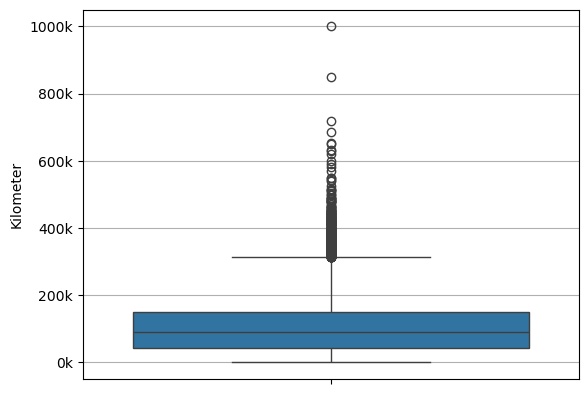

In [23]:
from matplotlib.ticker import FuncFormatter
def to_thousands(x, pos):
    return f"{int(x/1000)}k"

fig, ax = plt.subplots()

a = sns.boxplot(data=df["Kilometer"], ax=ax)
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_thousands))
ax.set_ylabel("Kilometer")
ax.yaxis.grid(True)
plt.show()

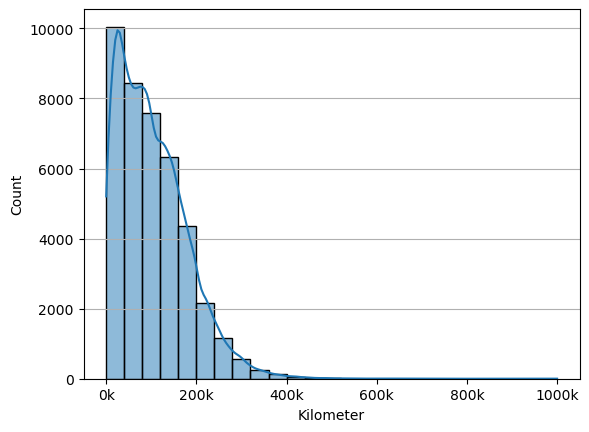

In [24]:
fig, ax = plt.subplots()
b = sns.histplot(data=df["Kilometer"], bins=25, kde=True, ax=ax)
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_thousands))
ax.yaxis.grid(True)
plt.show()

Observations:
- Data is right-skewed or positive skewed.
- The mean Kilometers of all cars being promoted on *StandVirtual* is about 100k km, the median however is 90k km.
- There are some outliers, i.e. cars promoted with more than 300k km
- The most extreme case is a car being promoted with 999k km
- Though *StandVirtual* has lots of cars with some km, there are some which are pratically as new where the km value $\in [1, 41k]$

### 2.2 Gas Type Analysis

This feature is categorical. Let us first find how many categories there are in the whole dataset:

In [25]:
len(df["Gas Type"].unique())

8

There are 8 different gas types, namely:

In [26]:
df["Gas Type"].value_counts()

Gas Type
Diesel                19789
Gasolina              13932
Eléctrico              3550
Híbrido Plug-In        2449
Híbrido (Gasolina)      953
GPL                     244
Híbrido (Diesel)        169
GNC                      19
Name: count, dtype: int64

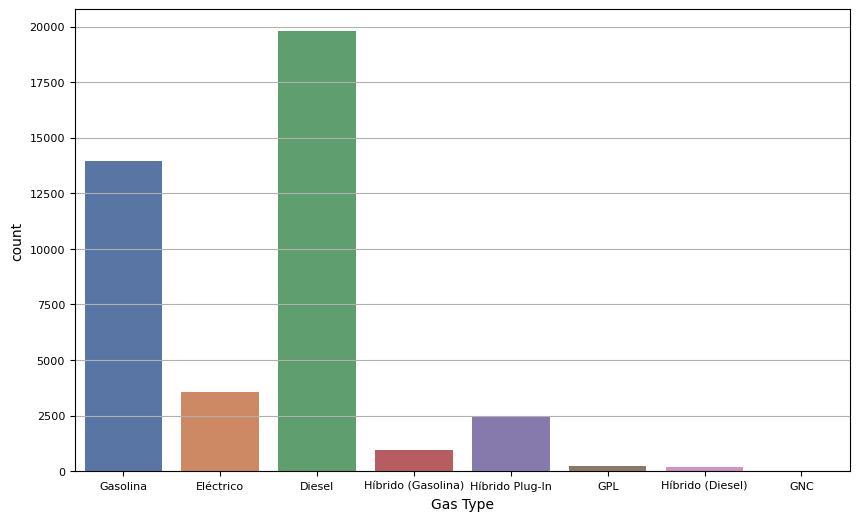

In [84]:
fig, ax = plt.subplots( figsize=(10, 6))
b = sns.countplot(data=df, x="Gas Type", hue="Gas Type", palette="deep", ax=ax, legend=False)
ax.yaxis.grid(True)
ax.xaxis.label.set_size(10)
b.tick_params(labelsize=8)
plt.show()

Observations:
- The most common gas type is diesel followed by gasolina, and the lest common type is GNC.
- GPL and Hybrid Diesel are equally common

### 2.3 Gear Box Analysis

This feature is also categorical. The categories are the following:
* Automatic;
* Manual

Their distribution in the datase is the following:

In [28]:
df["Gear Box"].value_counts()

Gear Box
Manual        22191
Automática    18902
Name: count, dtype: int64

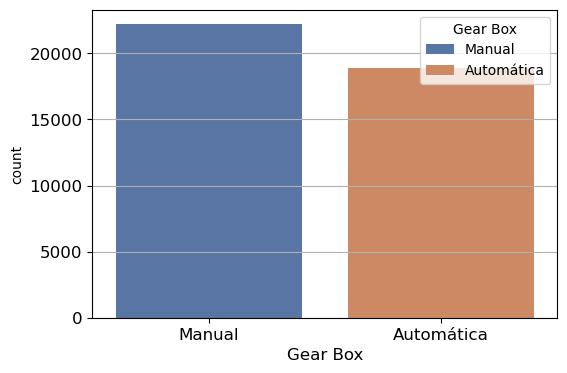

In [86]:
fig, ax = plt.subplots( figsize=(6, 4))
b = sns.countplot(data=df, x = "Gear Box", hue="Gear Box", palette="deep", ax=ax)
ax.yaxis.grid(True)
ax.xaxis.label.set_size(12)
b.tick_params(labelsize=12)
plt.show()

Observations:
* Both categories are almost equally present, being the manual type slightly more common than the automatic, perhaps a reflection of the average age of the car parc in Portugal of approximately [14 years](https://www.aut.fi/en/statistics/international_statistics/average_age_of_passenger_cars_in_european_countries).

### 2.4 Brand Analysis

This feature is categorical. We have already found that there were a total of 88 different brands in the dataset. 
Let us find the top 10 brands with respect to the total number of cars being promoted:

In [30]:
df["Brand"].value_counts().iloc[0:10]

Brand
Mercedes-Benz    5118
BMW              4397
Peugeot          4352
Renault          3783
VW               2108
Citroën          1859
Audi             1631
Fiat             1511
Opel             1458
Ford             1452
Name: count, dtype: int64

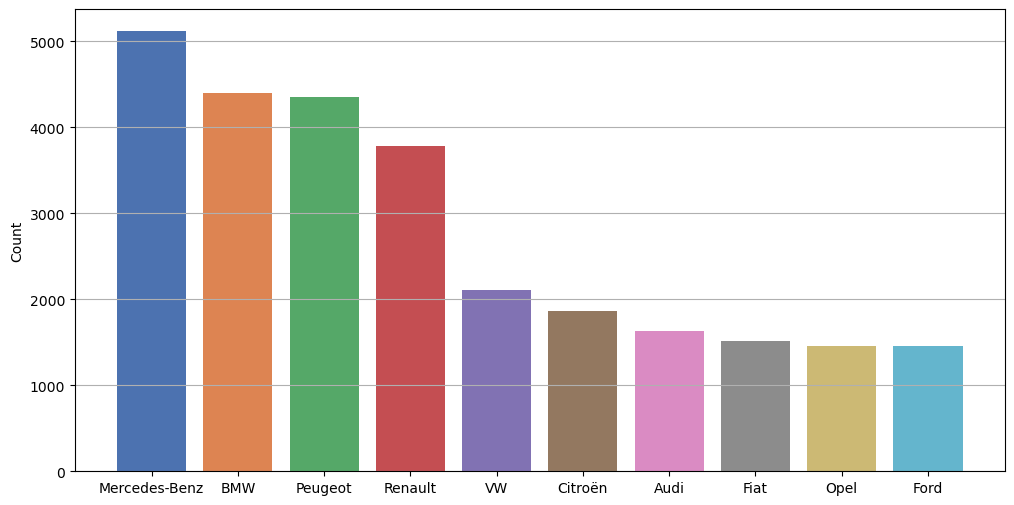

In [90]:
colors = sns.color_palette("deep", len(top_10_brands))
top_10_brands = df["Brand"].value_counts().iloc[0:10]
fig, ax = plt.subplots( figsize=(12, 6))
ax.bar(x=top_10_brands.index, height=top_10_brands.values, color=colors)
ax.yaxis.grid(True)
ax.set_ylabel("Count")
ax.xaxis.label.set_size(12)
b.tick_params(labelsize=12)
plt.show()

Observations:
- Mercedes-Benz dominates *StandVirtual* market with more than 5.000 cars being promoted, with BMW in second place;
- The number of cars listed from Audi, Fiat, Opel and Ford is almost the same $\approx 1500$

### 2.5 Car Age Distribution

Tis feature represents the year of manufacture of the car being promoted.

This variable is numeric, though it is possible to treat each year as a distinct category as well.

In [32]:
df["Year"].value_counts().iloc[0:15]

Year
2019.0    4542
2023.0    4010
2020.0    3839
2021.0    3819
2022.0    3777
2018.0    3679
2017.0    2719
2016.0    2205
2015.0    1846
2024.0    1631
2014.0    1473
2013.0    1088
2011.0     922
2012.0     886
2010.0     870
Name: count, dtype: int64

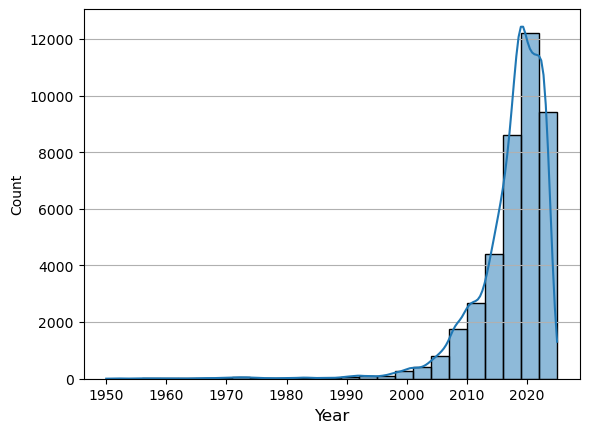

In [97]:
fig, ax = plt.subplots()
b = sns.histplot(data=df["Year"], bins=25, kde=True, ax=ax)
ax.yaxis.grid(True)
ax.xaxis.label.set_size(12)
plt.show()

In [99]:
top_15_years = df["Year"].value_counts().iloc[0:15]
years = str(top_15_years.index.values).strip("[]")
years = years.replace("\n", "") # remove \n
years = years.replace(".", "") # remove .
years = years.split() # split by whitespace char and store in list of strings

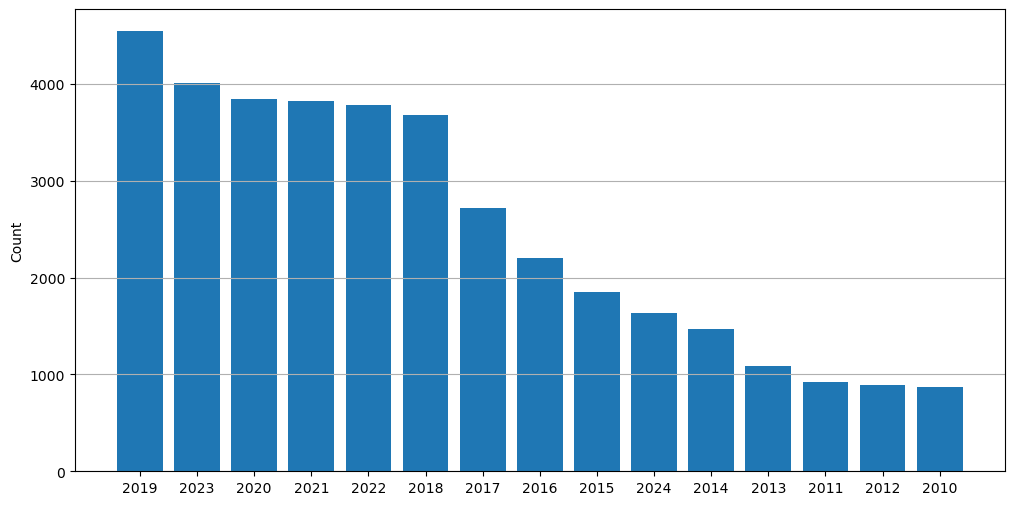

In [35]:
top_15_years = df["Year"].value_counts().iloc[0:15]
fig, ax = plt.subplots( figsize=(12, 6))
ax.bar(x=years, height=top_15_years.values)
ax.yaxis.grid(True)
ax.set_ylabel("Count")
ax.xaxis.label.set_size(12)
b.tick_params(labelsize=12)
plt.show()

Observations:
- The bar plot above shows the number of cars being promoted for a given year of model. Only the top 15 years of model with respect to number of cars being promoted are shown.
- These 15 years correspond to the last 15 years, including 2024. But their respective count cannot be directly correlated to the year. E.g. the year with the highest market share is 2019, followed by 2023
- This suggests that the majority of cars being promoted on *StandVirtual* are young.

We could treat the *Year* feature as a numeric one and show its distribution:

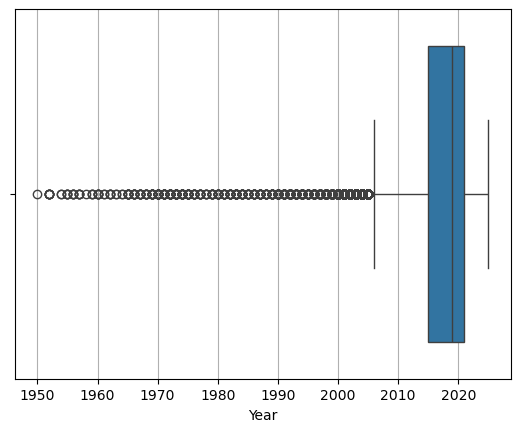

In [36]:
fig, ax = plt.subplots()

a = sns.boxplot(data=df, x = "Year", ax=ax)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(to_thousands))
ax.xaxis.grid(True)
plt.show()

Observations:
* The distribution is left or negatively skewed (the opposite of the *Kilometers* feature);
* The majority of vehicles bein promoted $\in [2000, 2024]$ 
* Because there are some outliers to the left (cars where the year of manufacture is older than 2000) the mean is lower than the median
* Visual comparison between this graph and the distribution of the *Kilometers* suggets that there is a negative correlation between these two variables.
* This would be of no surprise, because cars which were manufactured earlier have had more time to travel more kilometers compared to newer cars. Some older cars which are collectibles could be stored for some years and therefore may have not accumulated as much kilometers as non-collectibles. Still, overall, we expect older cars to have more kilometers than newer ones.

### 2.6 Price Distribution

In [72]:
df["Price"].mean()

26507.781462109233

Observations:
* The distribution is extremely right or positively skewed (much more than the *Kilometers* feature) - with the average price of ad listings on Standvirtual being EUR 26.508;
* The majority of vehicles bein promoted $\in [2000, 2024]$ 
* Because there are some outliers to the left (cars where the year of manufacture is older than 2000) the mean is lower than the median
* Visual comparison between this graph and the distribution of the *Kilometers* suggets that there is a negative correlation between these two variables.
* This would be of no surprise, because cars which were manufactured earlier have had more time to travel more kilometers compared to newer cars. Some older cars which are collectibles could be stored for some years and therefore may have not accumulated as much kilometers as non-collectibles. Still, overall, we expect older cars to have more kilometers than newer ones.


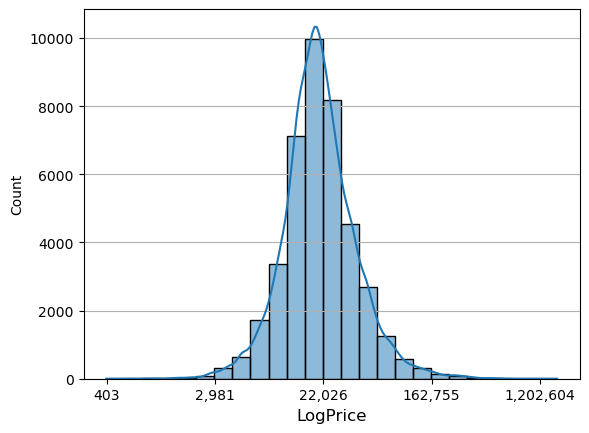

In [69]:
# Apply a log transformation to the 'Price' column to reduce skewness
df['LogPrice'] = np.log(df['Price'].replace(0, np.nan))  # Replace 0 values to avoid log(0) issues

# Create the plot
fig, ax = plt.subplots()

# Plot the histogram with log-transformed price
sns.histplot(data=df['LogPrice'], bins=25, kde=True, ax=ax)

# Function to format x-axis in thousands after exponentiating back
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{np.exp(x):,.0f}'))

# Set grid and labels
ax.yaxis.grid(True)
ax.xaxis.label.set_size(12)

# Display the plot
plt.show()

Observations:

* The log transformation helps in reducing the extreme right skew of the original data (wherein the mean price is EUR 26.508 and the median is EUR 19.900. Initially, most prices would have been concentrated towards the lower end, with a long tail of high prices extending far to the right. After the transformation, the distribution appears more balanced, and the range of values is compressed.

## 3. Bivariate Analysis

### 3.1 Simple Numerical Correlation of Variables

We start by computing the correlation matrix of the numeric variables.

In [38]:
df.corr(numeric_only=True)

,Kilometer,Year,Price
Kilometer,1.000000,-0.556910,-0.300134
Year,-0.556910,1.000000,0.146928
Price,-0.300134,0.146928,1.000000


Observations:
* Price is not strongly correlated with the *Kilometer* and *Year*;
* This is expected considering the original value of the vehciles is very different. There are 88 different brands and many different car models. The model alone will influence heavily the price of promotion. We cannot compare the price of a Mercedes-Benz from 2015 with a Peugeot from 2024. The Mercedes-Benz will be promoted at a higher price even though it is older and has more kilometers. Different cars with different problems and depreciations over time.
* To be able to estimate the promotion price of a given vehicle we have to analyse the dataframe by brand and model.

### 3.2 Correlation of Price & Kilometer by Brand

/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


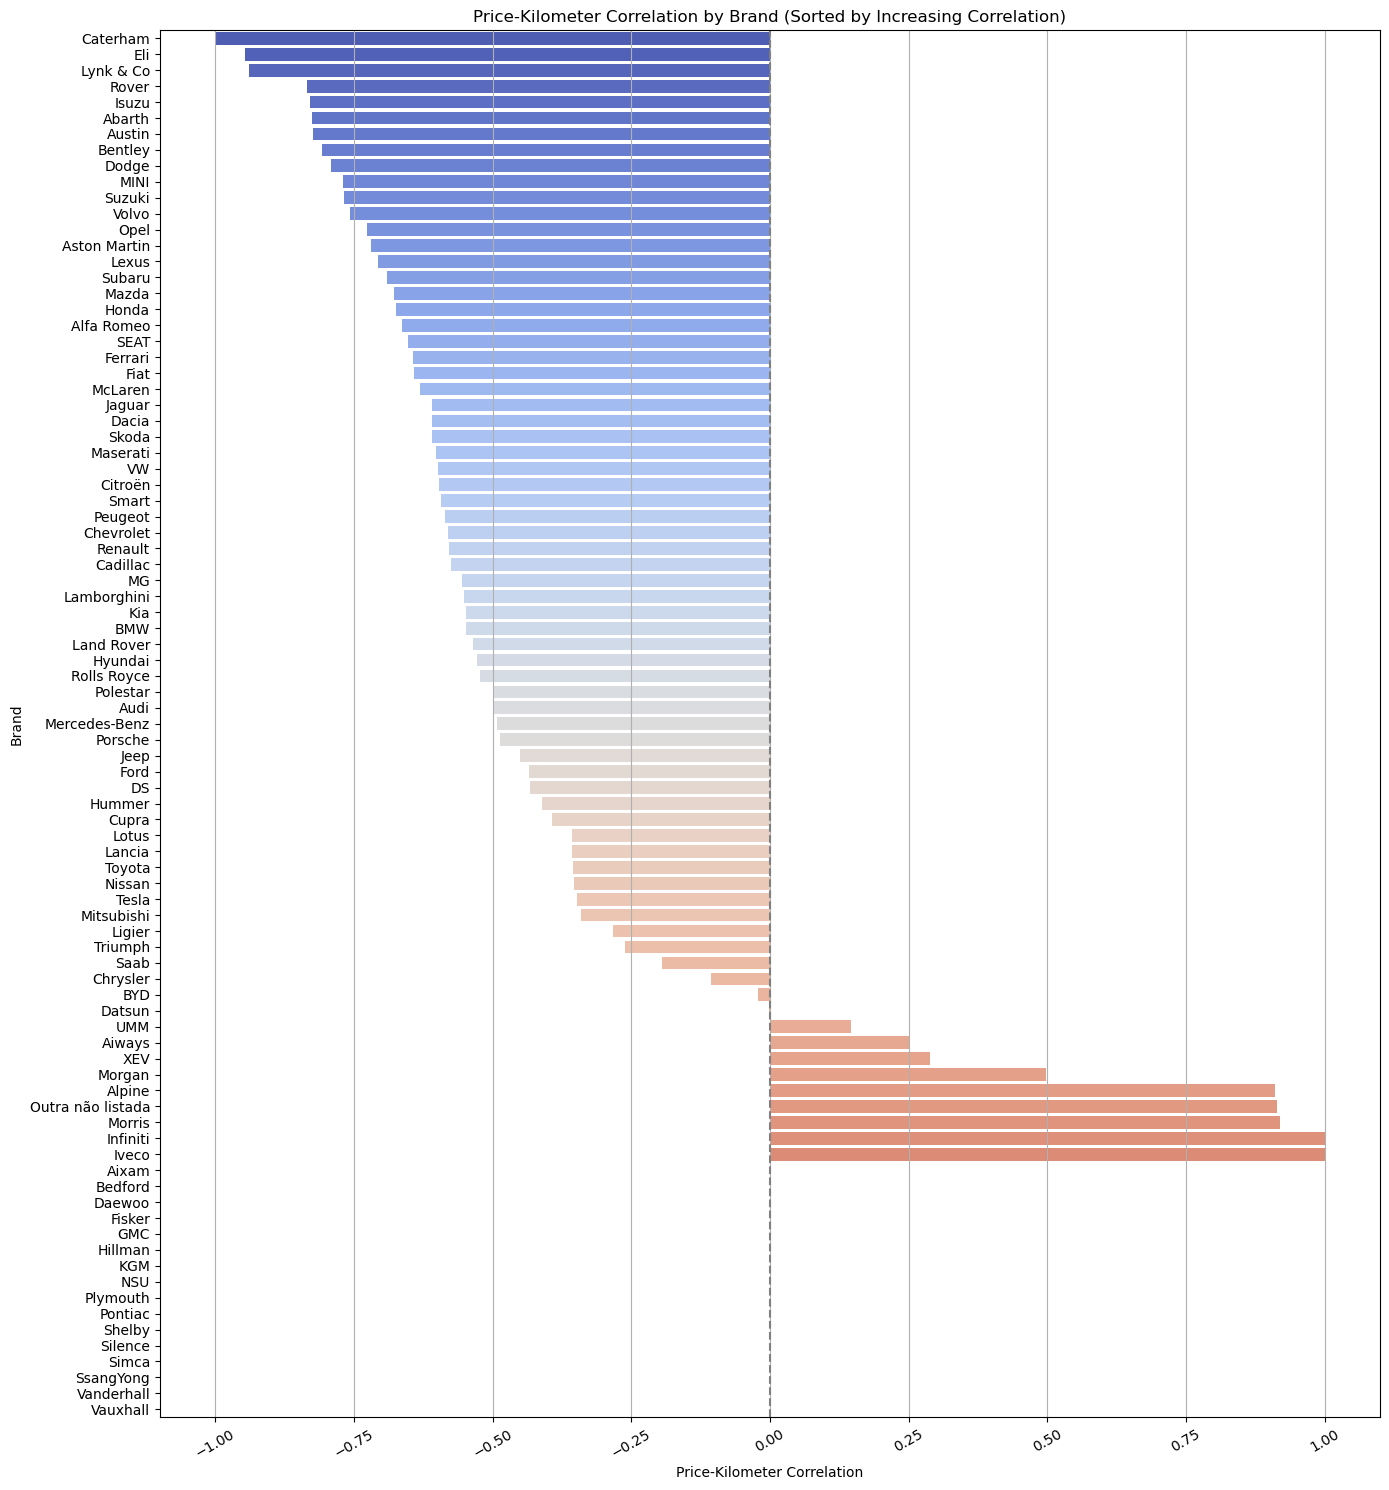

In [102]:
# Get unique brands
brands = df['Brand'].unique()

# Create an empty list to store results
results = []

for brand in brands:
    # Filter the DataFrame for the specific brand
    df_brand = df[df['Brand'] == brand]

    # Check if the filtered DataFrame is not empty
    if not df_brand.empty:
        # Calculate the correlation between Price and Kilometer
        correlation = df_brand['Price'].corr(df_brand['Kilometer'])
        
        # Append the result to the list
        results.append({'Brand': brand, 'Price-Kilometer Correlation': correlation})

# Create a DataFrame from the results
correlation_df = pd.DataFrame(results)

# Sort by increasing correlation
correlation_df.sort_values(by='Price-Kilometer Correlation', ascending=True, inplace=True)

# Plot the correlations using seaborn as a horizontal bar plot
plt.figure(figsize=(14, 15))  # Increase the figure size to accommodate all brands
sns.barplot(data=correlation_df, y='Brand', x='Price-Kilometer Correlation', hue='Brand', palette='coolwarm')

# Adding titles and labels
plt.title('Price-Kilometer Correlation by Brand (Sorted by Increasing Correlation)')
plt.xlabel('Price-Kilometer Correlation')
plt.ylabel('Brand')
plt.axvline(0, color='gray', linestyle='--')  # Add a vertical line at x=0
plt.grid(axis='x')  # Add gridlines for better readability

# Rotate x-axis labels for better readability
plt.xticks(rotation=30)  # Adjust rotation angle as needed

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the rotated labels
plt.show()


### 3.3 Correlation of Year & Kilometer by Brand

/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/cz/_h2n4h2x32bb7q77mgqn9jr80000gn/T/ipykernel_6036/2570216095.py:28: FutureWarning: 

Passing `palette` without

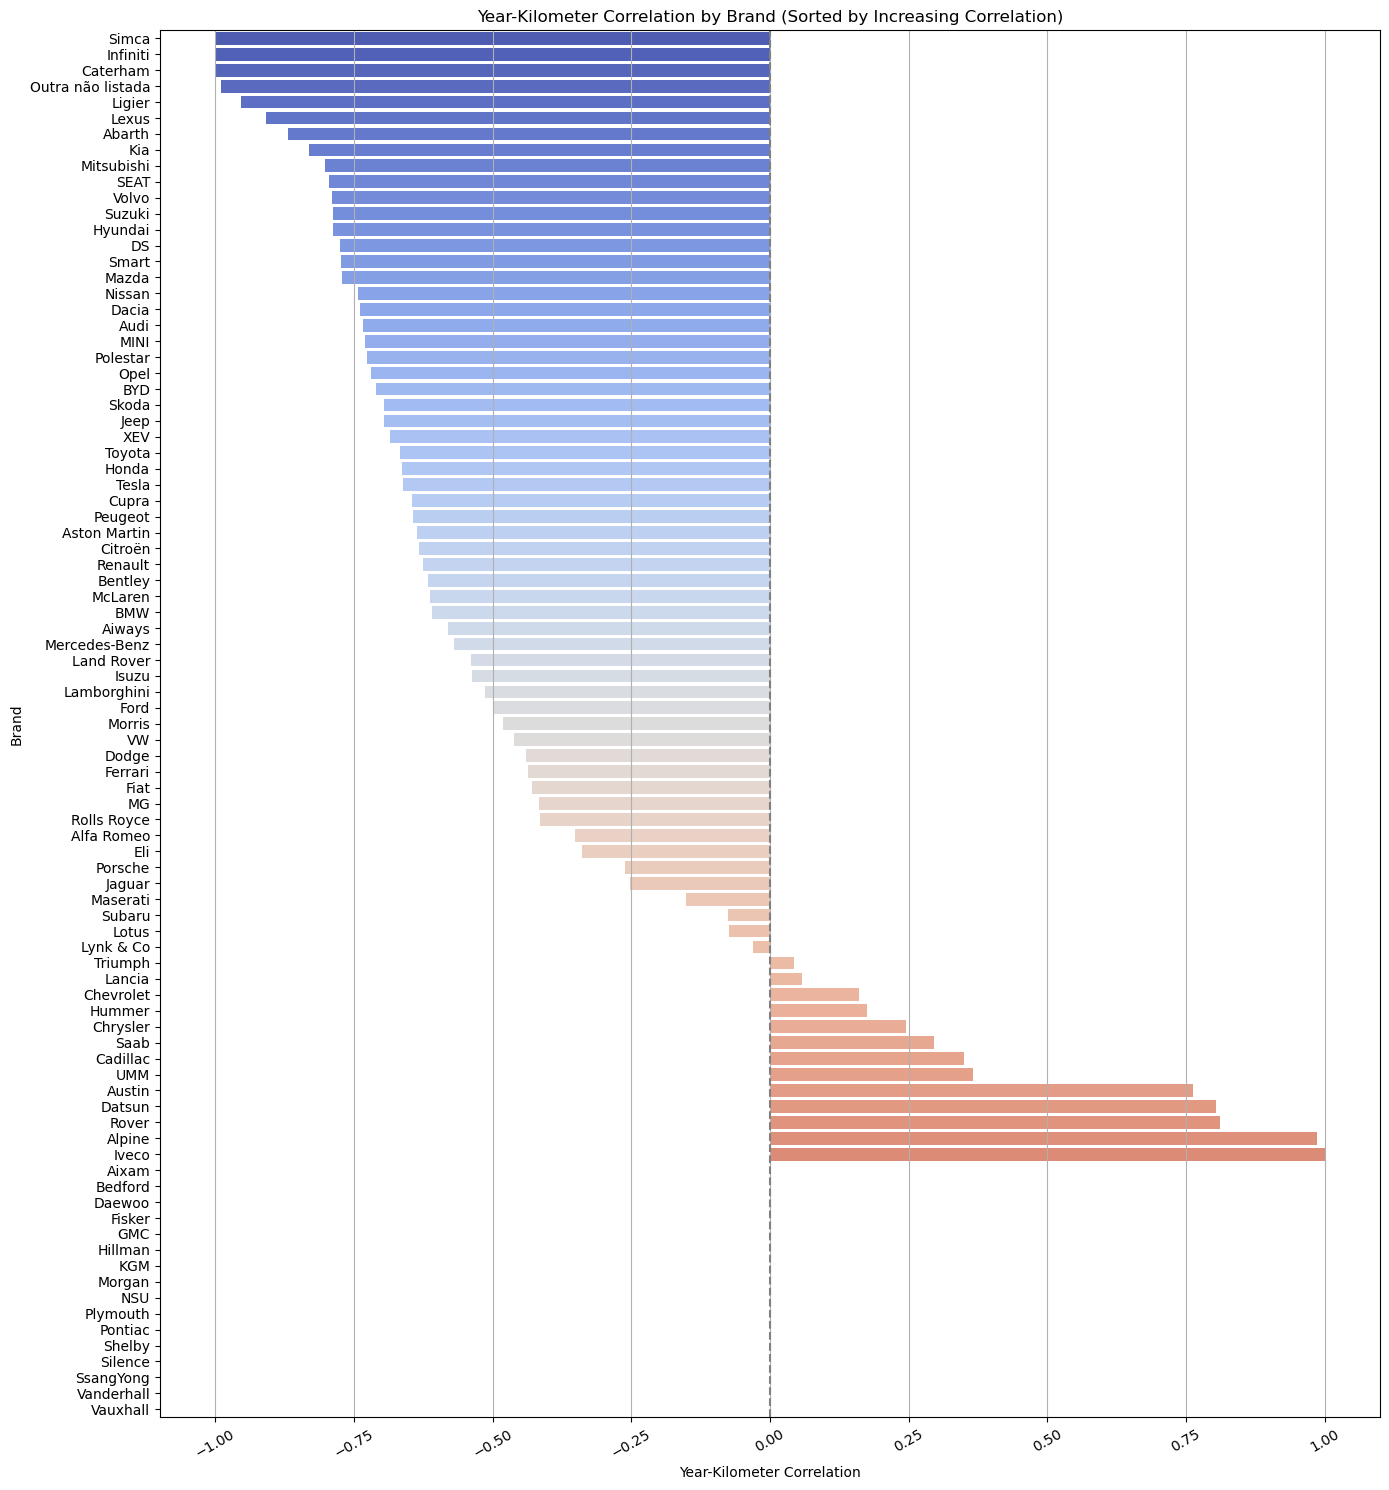

In [41]:
# Get unique brands
brands = df['Brand'].unique()

# Create an empty list to store results
results = []

# Loop through each brand and calculate the Year-Kilometer correlation
for brand in brands:
    # Filter the DataFrame for the specific brand
    df_brand = df[df['Brand'] == brand]

    # Check if the filtered DataFrame is not empty
    if not df_brand.empty:
        # Calculate the correlation between Year and Kilometer
        correlation = df_brand['Year'].corr(df_brand['Kilometer'])
        
        # Append the result to the list
        results.append({'Brand': brand, 'Year-Kilometer Correlation': correlation})

# Create a DataFrame from the results
correlation_df = pd.DataFrame(results)

# Sort by increasing correlation
correlation_df.sort_values(by='Year-Kilometer Correlation', ascending=True, inplace=True)

# Plot the correlations using seaborn as a horizontal bar plot
plt.figure(figsize=(14, 15))  # Increase the figure size to accommodate all brands
sns.barplot(data=correlation_df, y='Brand', x='Year-Kilometer Correlation', palette='coolwarm')

# Adding titles and labels
plt.title('Year-Kilometer Correlation by Brand (Sorted by Increasing Correlation)')
plt.xlabel('Year-Kilometer Correlation')
plt.ylabel('Brand')
plt.axvline(0, color='gray', linestyle='--')  # Add a vertical line at x=0
plt.grid(axis='x')  # Add gridlines for better readability

# Rotate x-axis labels for better readability
plt.xticks(rotation=30)  # Adjust rotation angle as needed

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the rotated labels
plt.show()

#### 3.3.1 Correlation of Price & Kilometer by Brand (Table)

In [42]:
# Get unique brands
brands = df['Brand'].unique()

# Create an empty list to store results
results = []

for brand in brands:
    # Filter the DataFrame for the specific brand
    df_brand = df[df['Brand'] == brand]

    # Check if the filtered DataFrame is not empty
    if not df_brand.empty:
        # Calculate the correlation between Price and Kilometer
        correlation = df_brand['Price'].corr(df_brand['Kilometer'])
        
        # Count the number of ad listings for the brand
        ad_count = df_brand.shape[0]  # Number of rows for that brand
        
        # Append the result to the list
        results.append({'Brand': brand, 'Price-Kilometer Correlation': correlation, 'Ad Count': ad_count})

# Create a DataFrame from the results
correlation_df = pd.DataFrame(results)

# Sort by increasing correlation
correlation_df.sort_values(by='Price-Kilometer Correlation', ascending=True, inplace=True)

# Set pandas option to display all rows
pd.set_option('display.max_rows', None)

# Display the resulting DataFrame
print(correlation_df)

                Brand  Price-Kilometer Correlation  Ad Count
13           Caterham                    -1.000000         2
23                Eli                    -0.946524         7
46          Lynk & Co                    -0.938833         4
67              Rover                    -0.835301         4
34              Isuzu                    -0.829705        12
0              Abarth                    -0.824929        93
7              Austin                    -0.824401         3
9             Bentley                    -0.808423        38
21              Dodge                    -0.792236        23
52               MINI                    -0.768986      1049
77             Suzuki                    -0.767449        64
84              Volvo                    -0.757954      1040
58               Opel                    -0.725981      1458
5        Aston Martin                    -0.719274        35
43              Lexus                    -0.706704       150
76             Subaru   

/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/DSPythonV1/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## 4. Supervised Machine Learning


#### 4.2 Linear Regression with Year, Kilometers & Gas Type

Model Coefficients: [-2.90980130e+02 -1.23198925e-01  2.88794518e+03 -1.41176382e+04
 -1.16441531e+04 -2.32353486e+03  1.01760452e+04  3.53715068e+03
  1.63291871e+04]
Intercept: 625867.7262037256
R-squared: 0.13709767457934907
Mean Squared Error: 586418118.4223523


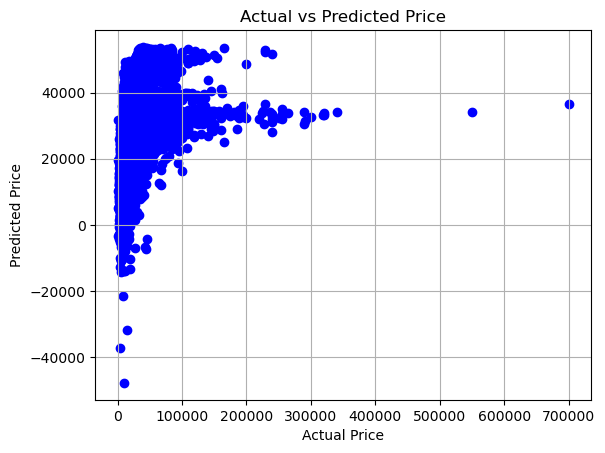

In [44]:
# Step 1: Perform One-Hot Encoding on the 'Gas Type' column
df_encoded = pd.get_dummies(df, columns=['Gas Type'], drop_first=True)  # drop_first=True avoids multicollinearity

# Step 2: Define the dependent variables (features) and independent variable (target)
X = df_encoded[['Year', 'Kilometer'] + [col for col in df_encoded.columns if 'Gas Type' in col]]  # Features: Year, Kilometer, and encoded gas types
y = df_encoded['Price']  # Target: Price

# Step 3: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Predict the test set results
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the coefficients and intercept
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

# Optional: Plot actual vs predicted prices
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.grid(True)
plt.show()

Observations

* The categorical variable Gas Type was converted to a binary column using 'One Hot Encoding'.
* Even so, the linear regression model with this additional categorical variable does not predict, with any significant accuracy, the price of an ad listing.

#### 4.3.1 Title & Car Model Association

* A list of all unique car models within the 41.106 listings on *Standvirtual* was created, such that each ad listing could be associated to a specific car model.
* This association was used to allow the new, categorical, variable model to be converted to a binary column so as to allows us to use it in a linear regression model.

In [46]:
# Load the car models file
car_models_df = pd.read_csv('car-models.csv', sep = ";")  # Load car models

# Remove accents from the 'Title' column
df['Title'] = df['Title'].apply(lambda x: unidecode(str(x)))

# Replace all "VW" with "Volkswagen" in the 'Title' column
df['Title'] = df['Title'].str.replace('VW', 'Volkswagen')

# Create a new column for matched models
df['Model'] = None

# Define a function to match models based on word matching
def is_model_in_title(model: str, title: str)->bool:
    model_words = set(model.split())  # Split model into words
    title_words = set(title.split())  # Split title into words
    return model_words.issubset(title_words)  # Check if all model words are in the title, returns 'True' or 'False'

# Define a function to match BMW series based on the title pattern
def match_bmw_series(title):
    match = re.search(r'BMW (\d)\d{2}', title)  # Look for "BMW" followed by a single digit and then two digits
    if match:
        series_number = match.group(1)  # Capture the series number
        return f'BMW Serie {series_number}'
    return None

car_models_df = car_models_df.set_index(["Brand"])
# Loop through each row in car-data
for index, row in df.iterrows():
    title = row['Title']
    
    # Special handling for BMW titles
    if "BMW" in title:
        bmw_series = match_bmw_series(title)  # Check for BMW series pattern
        if bmw_series:
            df.at[index, 'Model'] = bmw_series
            continue  # Skip further matching if BMW series is found
    
    # Otherwise, perform regular model matching
    current_brand = row["Brand"] 

    try:
        models_current_brand = car_models_df.loc[current_brand, :] 

        for model in models_current_brand['Name']:
            # Check if all words in the model are in the title
            if is_model_in_title(model, title):
                # Store the matched model
                df.at[index, 'Model'] = model
                break  # Stop checking after the first match

    except:
        for model in car_models_df['Name']:
        # Check if all words in the model are in the title
            if is_model_in_title(model, title):
                # Store the matched model
                df.at[index, 'Model'] = model
                break  # Stop checking after the first match

# Save the result to a new CSV file
df.to_csv('car-data-with-model.csv', index=False, encoding='utf-8-sig')
print("Matching complete. Results saved to 'car-data-with-model.csv'.")

Matching complete. Results saved to 'car-data-with-model.csv'.


##### Show table of Title & Car Model Association

In [49]:
df.head()

,Brand,Title,Kilometer,Gas Type,Gear Box,Year,Price,Model
0,Abarth,Abarth 595 Turismo,145000.0,Gasolina,Manual,2015.0,16000.0,Abarth 595 Turismo
1,Abarth,Abarth 500e,1.0,Eléctrico,Automática,2024.0,37981.0,Abarth 500e
2,Abarth,Abarth 695 1.4 T-Jet MTA,1.0,Gasolina,Automática,2024.0,36612.0,Abarth 695
3,Abarth,Abarth 500 1.4 16V,122000.0,Gasolina,Manual,2009.0,13990.0,Abarth 500
4,Abarth,Abarth 595 1.4 T-Jet Competizione MTA,134000.0,Gasolina,Automática,2016.0,18999.0,Abarth 595


#### 4.3.2 Linear Regression Analysis of Price using Kilometer, Year, Model & Gas Type

Model Coefficients: [ 7.99045323e+02 -7.17641240e-02  1.10041344e+04 -5.56291554e+02
 -2.06476967e+03  8.04401805e+03 -3.19468644e+03 -1.17113753e+03
 -4.09753062e-04 -2.76838679e+03 -3.29305295e+03  4.62708769e+03
  2.24957903e+03 -2.04913466e+03  6.95025752e+02 -1.22412365e+04
 -1.72460925e+03  4.12607213e+03 -2.03464010e+02  7.41638623e+03
  3.29894701e+04 -8.71313096e-05  7.92281735e+03  1.90610346e+02
  1.55566119e+04  1.64439246e+04 -1.46925029e+03  1.12550204e+04
 -6.18252755e+03  1.09577032e+05  1.08529752e+04  1.53606083e+04
  1.33048201e+04  5.61649746e+03  3.31348493e+04  1.41636061e+05
  2.93634387e+05  6.14854039e+04  7.61381110e+04  3.48807098e+05
  1.52971723e+05  9.03019018e+04  1.13824732e+05  1.42671857e+05
  1.01349956e+05  3.81212449e-05 -4.02481073e+03  8.54624068e+03
  5.24399215e+01  5.22888219e+03  8.88406022e+03  1.25718287e+04
  1.76415803e+04  2.30070791e+04 -8.51555549e+02  9.53772478e+03
  2.10315373e+04  1.23020400e+04  1.97217288e+04  4.77690500e+04
  1.0

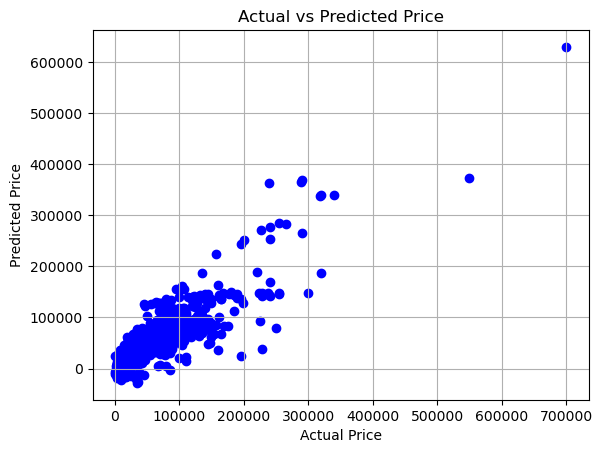

In [55]:
# Step 1: Perform One-Hot Encoding on the 'Gas Type' column
df_encoded = pd.get_dummies(df, columns=['Model', 'Gas Type'], drop_first=True)  # drop_first=True avoids multicollinearity

# Step 2: Define the dependent variables (features) and independent variable (target)
X = df_encoded[['Year', 'Kilometer'] + [col for col in df_encoded.columns if ("Model" in col or "Gas Type" in col)]]  # Features: Year, Kilometer, and encoded gas types
y = df_encoded['Price']  # Target: Price

# Step 3: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Predict the test set results
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the coefficients and intercept
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

# Optional: Plot actual vs predicted prices
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.grid(True)
plt.show()

Observations

* As can be seen by the graph above, by controlling for the variable 'Model' we were able to get a very substantial improvement in the predictive capabilities of our regression model. 
* The improvement may be, primarily, explained by two aspects:
    * Different car models often have different price points, even for cars with similar kilometers and years
    * The relationship between price and other variables may not be strictly linear. Different car models might exhibit unique price behaviors

#### 4.3.3 Linear Regression Analysis of Price using Kilometer, Year, Model, Gas Type & KM-Year

In [59]:
df["KM-Year"] = df["Kilometer"] / df["Year"]
df.head()

,Brand,Title,Kilometer,Gas Type,Gear Box,Year,Price,Model,KM-Year
0,Abarth,Abarth 595 Turismo,145000.0,Gasolina,Manual,2015.0,16000.0,Abarth 595 Turismo,71.960298
1,Abarth,Abarth 500e,1.0,Eléctrico,Automática,2024.0,37981.0,Abarth 500e,0.000494
2,Abarth,Abarth 695 1.4 T-Jet MTA,1.0,Gasolina,Automática,2024.0,36612.0,Abarth 695,0.000494
3,Abarth,Abarth 500 1.4 16V,122000.0,Gasolina,Manual,2009.0,13990.0,Abarth 500,60.726730
4,Abarth,Abarth 595 1.4 T-Jet Competizione MTA,134000.0,Gasolina,Automática,2016.0,18999.0,Abarth 595,66.468254


Model Coefficients: [ 9.87857710e+02 -3.43706176e+00  6.77761543e+03  1.09811717e+04
 -2.05649188e+02 -1.64549132e+03  7.39258044e+03 -3.17842078e+03
 -1.69010085e+03  1.48094841e-07 -2.84039319e+03 -3.27475932e+03
  3.65617057e+03  1.94780945e+03 -1.73398472e+03  1.04593514e+03
 -1.27241326e+04 -2.57165332e+03  1.87315322e+03 -7.69191624e+02
  7.22327001e+03  3.31499045e+04 -3.10639734e-07  7.85335851e+03
  9.05601898e+02  1.68706109e+04  1.63858709e+04 -1.38403901e+03
  1.03573204e+04 -6.22990797e+03  1.11401179e+05  1.20304649e+04
  1.40424540e+04  1.34146460e+04  4.72583915e+03  3.27813898e+04
  1.41588094e+05  2.92304912e+05  6.35572762e+04  7.72202191e+04
  3.48278093e+05  1.52702846e+05  9.07972008e+04  1.13877847e+05
  1.43534762e+05  1.02274664e+05  5.85278030e-07 -4.07520739e+03
  4.68005242e+03 -1.49078479e+02  4.91475893e+03  8.78146530e+03
  1.22620366e+04  1.76949604e+04  2.20101043e+04 -1.10543431e+03
  9.42517828e+03  2.08316332e+04  1.22302739e+04  1.93516304e+04
  4.7

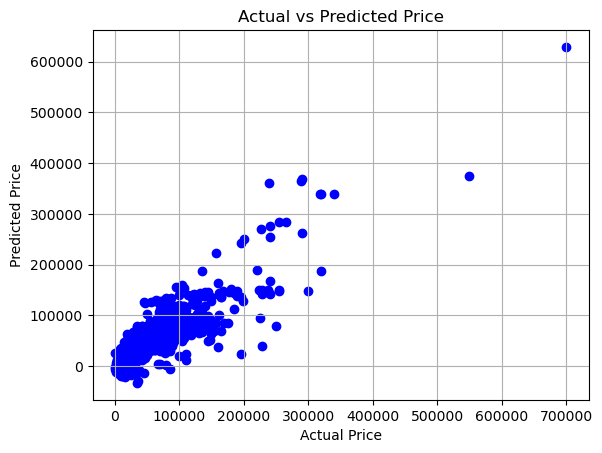

In [60]:
# Step 1: Perform One-Hot Encoding on the 'Gas Type' column
df_encoded = pd.get_dummies(df, columns=['Model', 'Gas Type'], drop_first=True)  # drop_first=True avoids multicollinearity

# Step 2: Define the dependent variables (features) and independent variable (target)
X = df_encoded[['Year', 'Kilometer', "KM-Year"] + [col for col in df_encoded.columns if ("Model" in col or "Gas Type" in col)]]  # Features: Year, Kilometer, and encoded gas types
y = df_encoded['Price']  # Target: Price

# Step 3: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Predict the test set results
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the coefficients and intercept
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

# Optional: Plot actual vs predicted prices
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.grid(True)
plt.show()